# Data Preprocessing for A/B testing.

Data is acquired from [Kaggle](https://www.kaggle.com/datasets/putdejudomthai/ecommerce-ab-testing-2022-dataset1). The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product.


The goals of this analysis is to evaluate whether the new landing page (“new_page”) is better in terms of ***conversion*** rate than the old landing page (“old_page”). help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats

#setup max column
pd.set_option('display.max_columns', None)

# Read Data

In [2]:
df_ab = pd.read_csv('/content/ab_data.csv')
df_countries = pd.read_csv('/content/countries.csv')

In [3]:
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


**Data description:**

- user_id : Unique identifier for each user/session. Each row represents one observation.
- timestamp : The time when the user interacted with the landing page (session time).
- group : A/B test group assignment: control = users assigned to the old page, treatment = users assigned to the new page.
- landing_page : The actual landing page displayed to the user. Sometimes it mismatches the group (mis-assignment).
- converted : Indicates whether the user converted (1 = conversion, 0 = no conversion). A “conversion” typically means completing a purchase or desired action.

In [4]:
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


**Data description**:
- user_id : Matches with user_id in ab_data to join country info.
- country : The country of the user. Useful for segmented analysis.

## Value count

In [5]:
# for loop value count in each columns

for col in df_ab.columns:
    print(f"Value counts for column '{col}':")
    print(df_ab[col].value_counts())
    print("\n")

Value counts for column 'user_id':
user_id
764461    2
752737    2
781280    2
767913    2
886060    2
         ..
653383    1
732573    1
867433    1
899189    1
900200    1
Name: count, Length: 290585, dtype: int64


Value counts for column 'timestamp':
timestamp
33:53.2    22
36:26.7    22
53:18.9    21
56:02.7    21
27:20.8    21
           ..
41:52.3     1
42:49.5     1
08:45.2     1
47:34.1     1
52:49.2     1
Name: count, Length: 35993, dtype: int64


Value counts for column 'group':
group
treatment    147278
control      147202
Name: count, dtype: int64


Value counts for column 'landing_page':
landing_page
new_page    147241
old_page    147239
Name: count, dtype: int64


Value counts for column 'converted':
converted
0    259243
1     35237
Name: count, dtype: int64




In [6]:
# for loop value count in each columns

for col in df_countries.columns:
    print(f"Value counts for column '{col}':")
    print(df_countries[col].value_counts())
    print("\n")

Value counts for column 'user_id':
user_id
759899    2
763147    1
907039    1
750441    1
808681    1
         ..
698482    1
676912    1
932832    1
764449    1
752105    1
Name: count, Length: 290585, dtype: int64


Value counts for column 'country':
country
US    203621
UK     72466
CA     14499
Name: count, dtype: int64




## nunique

In [7]:
df_ab.nunique()

,0
user_id,290585
timestamp,35993
group,2
landing_page,2
converted,2


In [8]:
df_countries.nunique()

,0
user_id,290585
country,3


## Merge dataset

In [9]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [11]:
df_ab.shape

(294480, 5)

In [12]:
df_countries.shape

(290586, 2)

In [13]:
# Merge on user_id
df_merge = pd.merge(df_ab, df_countries, on="user_id", how="inner")

# Check result
print(df_merge.head())
print("Shape after merge:", df_merge.shape)


   user_id timestamp      group landing_page  converted country
0   851104   11:48.6    control     old_page          0      US
1   804228   01:45.2    control     old_page          0      US
2   661590   55:06.2  treatment     new_page          0      US
3   853541   28:03.1  treatment     new_page          0      US
4   864975   52:26.2    control     old_page          1      US
Shape after merge: (294482, 6)


# Data Preprocessing

## Change data type


### change value on columns converted to boolean type

In [14]:
# before
df_merge.head(2)

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US


In [15]:
df_merge['converted'].value_counts()

,count
converted,
0,259245
1,35237


In [16]:
df_merge['converted'] = df_merge['converted'].astype(bool)

In [17]:
# after
df_merge.head(2)

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,False,US
1,804228,01:45.2,control,old_page,False,US


In [18]:
df_merge['converted'].value_counts()

,count
converted,
False,259245
True,35237


## Clean Data
delete mis-assignment to avoid bias in the validation process

In [19]:
df_merge.groupby(['group', 'landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145315
3,treatment,old_page,1965


### Proportion mis-assignment

In [20]:
# group control
control_newpage = 1928
control_oldpage = 145274

# group treatment
treatment_newpage = 145315
treatment_oldpage = 1965



In [21]:
# expected
control_oldpage = 145274
treatment_newpage = 145315

total_expected = control_oldpage + treatment_newpage
total_expected

290589

In [22]:
# mis-assignment
control_newpage = 1928
treatment_oldpage = 1965

total_misassignment = control_newpage + treatment_oldpage
total_misassignment

3893

In [23]:
# hitung proporsi

total_misassignment / (total_expected + total_misassignment)*100

1.3219823282917122

### clean mis-assignment


In [24]:
# before
df_merge.groupby(['group', 'landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145315
3,treatment,old_page,1965


In [25]:
# before
df_merge.shape

(294482, 6)

In [26]:
# mis-assignment
control_newpage = 1928
treatment_oldpage = 1965

total_misassignment = control_newpage + treatment_oldpage
total_misassignment

3893

In [27]:
# cek data mis- assignment

mis_assign = df_merge[
    ((df_merge['group'] == 'control') & (df_merge['landing_page'] == 'new_page')) |
    ((df_merge['group'] == 'treatment') & (df_merge['landing_page'] == 'old_page'))
]

print("Jumlah baris mis-assignment:", mis_assign.shape[0])
print(mis_assign.head())


Jumlah baris mis-assignment: 3893
     user_id timestamp      group landing_page  converted country
22    767017   58:15.0    control     new_page      False      US
240   733976   11:16.4    control     new_page      False      US
308   857184   34:59.8  treatment     old_page      False      US
327   686623   26:40.7  treatment     old_page      False      US
357   856078   29:30.4  treatment     old_page      False      US


In [28]:
# delete / drop

df_clean = df_merge.drop(mis_assign.index)
print('size data awal.  :', df_merge.shape)
print('size data akhir. :', df_clean.shape)

size data awal.  : (294482, 6)
size data akhir. : (290589, 6)


In [29]:
# validasi / check

check_invalid = df_clean[
    ((df_clean['group'] == 'control') & (df_clean['landing_page'] == 'new_page')) |
    ((df_clean['group'] == 'treatment') & (df_clean['landing_page'] == 'old_page'))
]

print("Sisa mis-assignment:", check_invalid.shape[0])

Sisa mis-assignment: 0


## Missing Value Check

In [30]:
df_clean.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0
country,0


In [31]:
df_clean.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0
country,0


***There is no missing value***

## Duplicate Check

In [32]:
df_clean.duplicated().sum()

np.int64(2)

In [33]:
df_clean.value_counts()

user_id  timestamp  group      landing_page  converted  country
759899   20:29.0    treatment  new_page      False      US         2
         07:36.1    treatment  new_page      False      US         2
840705   48:08.5    treatment  new_page      False      UK         1
840704   12:04.3    control    old_page      False      US         1
840703   24:38.8    treatment  new_page      False      UK         1
                                                                  ..
735297   49:09.3    treatment  new_page      False      UK         1
735296   06:51.1    control    old_page      False      US         1
735295   46:40.7    control    old_page      False      US         1
735294   03:08.0    treatment  new_page      False      UK         1
735302   51:13.1    treatment  new_page      False      US         1
Name: count, Length: 290587, dtype: int64

In [34]:
# Show duplicated
df_clean[df_clean.duplicated()]

,user_id,timestamp,group,landing_page,converted,country
250002,759899,07:36.1,treatment,new_page,False,US
294480,759899,20:29.0,treatment,new_page,False,US


In [35]:
# Show duplicated value
df_clean[df_clean.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted,country
250001,759899,07:36.1,treatment,new_page,False,US
250002,759899,07:36.1,treatment,new_page,False,US
294479,759899,20:29.0,treatment,new_page,False,US
294480,759899,20:29.0,treatment,new_page,False,US


In [36]:
# before drop
df_clean.shape

(290589, 6)

In [37]:
# drop the duplicate

df_clean = df_clean.drop_duplicates()

In [38]:
# check the duplicate

df_clean.duplicated().sum()

np.int64(0)

In [39]:
# after drop
df_clean.shape

(290587, 6)

In [40]:
# Double Check Show duplicated value
df_clean[df_clean.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted,country


## Check SRM

SRM is a condition where the number of samples entering each group in an A/B experiment does not match the planned proportions. It identifies significant imbalances between the treatment and control groups.

Sample Ratio Mismatch (SRM) https://www.convert.com/blog/a-b-testing/sample-ratio-mismatch-srm-guide

### General

In [41]:
df_clean['landing_page'].value_counts()

,count
landing_page,
new_page,145313
old_page,145274


In [42]:
observed_landing_page = [145313, 145274]  # [new_page, old_page]

# Jumlah data yang di observasi
total = sum(observed_landing_page)

# Proporsi yang diharapkan (50/50 split)
expected = [total/2, total/2]

# Chi-square test
chi2, p_value = stats.chisquare(f_obs=observed_landing_page, f_exp=expected)

print("Chi2 Statistic:", chi2)
print("p-value:", p_value)

if p_value < 0.05:
    print("Ada indikasi Sample Ratio Mismatch (SRM).")
else:
    print("Tidak ada indikasi SRM (pembagian sample normal).")


Chi2 Statistic: 0.005234232777102899
p-value: 0.9423249680712827
Tidak ada indikasi SRM (pembagian sample normal).


In [43]:
df_clean[['group','landing_page']].value_counts()

,,count
group,landing_page,
treatment,new_page,145313
control,old_page,145274


In [44]:
# calculate percentage
df_clean[['group','landing_page']].value_counts(normalize=True) * 100

,,proportion
group,landing_page,
treatment,new_page,50.006711
control,old_page,49.993289


In [45]:
# percentage of difference
(50.006711 - 49.993289) * 100

1.3422000000005596

In [46]:
# hitung selisih persentase
LP_diff_percentage = (50.006711 - 49.993289) * 100

print("Selisih persentase:", LP_diff_percentage)

Selisih persentase: 1.3422000000005596


### Visualization

/tmp/ipython-input-2685737861.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p_new = float(lp_agg.loc[lp_agg['landing_page']=='new_page', 'percentage'])
/tmp/ipython-input-2685737861.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p_old = float(lp_agg.loc[lp_agg['landing_page']=='old_page', 'percentage'])


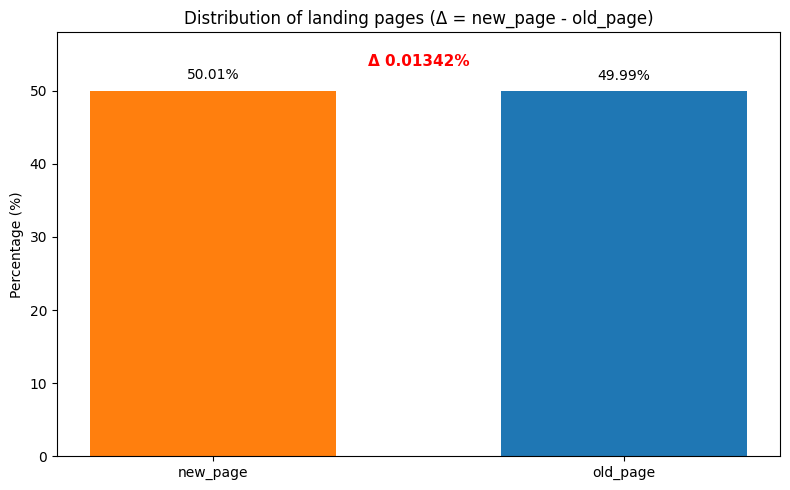

In [47]:
# --- create DataFrame  ---
df_counts = pd.DataFrame({
    'group': ['treatment', 'control'],
    'landing_page': ['new_page', 'old_page'],
    'count': [145313, 145274]
})

# --- agregasi per landing_page ---
lp_agg = df_counts.groupby('landing_page', as_index=False)['count'].sum()

# --- persentase ---
lp_agg['percentage'] = lp_agg['count'] / lp_agg['count'].sum() * 100

# --- urutkan new_page -> old_page ---
preferred = ['new_page', 'old_page']
lp_agg = lp_agg.set_index('landing_page').loc[preferred].reset_index()

# --- plotting ---
x = np.arange(len(lp_agg))
fig, ax = plt.subplots(figsize=(8,5))

colors = ['#FF7F0E' if lp == 'new_page' else '#1F77B4' for lp in lp_agg['landing_page']]
bars = ax.bar(x, lp_agg['percentage'], width=0.6, color=colors)

# label persentase
for i, row in lp_agg.iterrows():
    ax.annotate(f'{row["percentage"]:.2f}%',
                xy=(x[i], row['percentage']),
                xytext=(0, 6),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=10)

# anotasi Δ
p_new = float(lp_agg.loc[lp_agg['landing_page']=='new_page', 'percentage'])
p_old = float(lp_agg.loc[lp_agg['landing_page']=='old_page', 'percentage'])
diff = p_new - p_old

x_center = (x[0] + x[1]) / 2.0
y_pos = lp_agg['percentage'].max() + 3
ax.annotate(f'Δ {diff:.5f}%',
            xy=(x_center, y_pos),
            ha='center', va='bottom',
            fontsize=11, fontweight='bold', color='red')

# dekorasi
ax.set_xticks(x)
ax.set_xticklabels(lp_agg['landing_page'])
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of landing pages (Δ = new_page - old_page)')
ax.set_ylim(0, np.nanmax(lp_agg['percentage']) + 8)
plt.tight_layout()
plt.show()

### by country

In [48]:
df_clean.groupby(['group','country','landing_page']).size().reset_index(name='count')

,group,country,landing_page,count
0,control,CA,old_page,7198
1,control,UK,old_page,36360
2,control,US,old_page,101716
3,treatment,CA,new_page,7301
4,treatment,UK,new_page,36106
5,treatment,US,new_page,101906


### US

In [49]:
# US

US_filtered = df_clean[df_clean['country'] == 'US']   # filter
US_filtered.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,old_page,101716
1,treatment,new_page,101906


In [50]:
# US Proportion

US_summary = (
    US_filtered
    .groupby(['group','landing_page'])
    .size()
    .reset_index(name='count')
)

# hitung proporsi (persentase)
US_summary['percentage'] = (US_summary['count'] / US_summary['count'].sum()) * 100
US_summary

,group,landing_page,count,percentage
0,control,old_page,101716,49.953345
1,treatment,new_page,101906,50.046655


In [51]:
# US
# hitung selisih persentase
US_diff_percentage = US_summary['percentage'].iloc[1] - US_summary['percentage'].iloc[0]

print("Selisih persentase:", US_diff_percentage)

Selisih persentase: 0.09331015312687185


In [52]:
# US SRM CHECK

US_observed_landing_page = [101906, 101716]  # [new_page, old_page]

# Jumlah data yang di observasi
total = sum(US_observed_landing_page)

# Proporsi yang diharapkan (50/50 split)
expected = [total/2, total/2]

# Chi-square test
chi2, p_value = stats.chisquare(f_obs=US_observed_landing_page, f_exp=expected)

print("Chi2 Statistic:", chi2)
print("p-value:", p_value)

if p_value < 0.05:
    print("Ada indikasi Sample Ratio Mismatch (SRM).")
else:
    print("Tidak ada indikasi SRM (pembagian sample normal).")

Chi2 Statistic: 0.17728929094105744
p-value: 0.6737132052609481
Tidak ada indikasi SRM (pembagian sample normal).


### UK

In [53]:
# UK

UK_filtered = df_clean[df_clean['country'] == 'UK']   # filter
UK_filtered.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,old_page,36360
1,treatment,new_page,36106


In [54]:
# UK Proportion

UK_summary = (
    UK_filtered
    .groupby(['group','landing_page'])
    .size()
    .reset_index(name='count')
)

# hitung proporsi (persentase)
UK_summary['percentage'] = (UK_summary['count'] / UK_summary['count'].sum()) * 100
UK_summary

,group,landing_page,count,percentage
0,control,old_page,36360,50.175255
1,treatment,new_page,36106,49.824745


In [55]:
# UK
# hitung selisih persentase
UK_diff_percentage = UK_summary['percentage'].iloc[1] - UK_summary['percentage'].iloc[0]

print("Selisih persentase:", UK_diff_percentage)

Selisih persentase: -0.35050920431651633


In [56]:
# UK SRM CHECK

UK_observed_landing_page = [36106, 36360]  # [new_page, old_page]

# Jumlah data yang di observasi
total = sum(UK_observed_landing_page)

# Proporsi yang diharapkan (50/50 split)
expected = [total/2, total/2]

# Chi-square test
chi2, p_value = stats.chisquare(f_obs=UK_observed_landing_page, f_exp=expected)

print("Chi2 Statistic:", chi2)
print("p-value:", p_value)

if p_value < 0.05:
    print("Ada indikasi Sample Ratio Mismatch (SRM).")
else:
    print("Tidak ada indikasi SRM (pembagian sample normal).")

Chi2 Statistic: 0.8902933789639279
p-value: 0.3453978173821527
Tidak ada indikasi SRM (pembagian sample normal).


### CA

In [57]:
# CA

CA_filtered = df_clean[df_clean['country'] == 'CA']   # filter
CA_filtered.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,old_page,7198
1,treatment,new_page,7301


In [58]:
# CA proportion

CA_summary = (
    CA_filtered
    .groupby(['group','landing_page'])
    .size()
    .reset_index(name='count')
    )

# hitung proporsi (persentase)
CA_summary['percentage'] = (CA_summary['count'] / CA_summary['count'].sum()) * 100
CA_summary

,group,landing_page,count,percentage
0,control,old_page,7198,49.644803
1,treatment,new_page,7301,50.355197


In [59]:
# CA
# hitung selisih persentase
CA_diff_percentage = CA_summary['percentage'].iloc[1] - CA_summary['percentage'].iloc[0]

print("Selisih persentase:", CA_diff_percentage)

Selisih persentase: 0.7103938202634694


In [60]:
# CA SRM CHECK

CA_observed_landing_page = [7301, 7198]  # [new_page, old_page]

# Jumlah data yang di observasi
total = sum(CA_observed_landing_page)

# Proporsi yang diharapkan (50/50 split)
expected = [total/2, total/2]

# Chi-square test
chi2, p_value = stats.chisquare(f_obs=CA_observed_landing_page, f_exp=expected)

print("Chi2 Statistic:", chi2)
print("p-value:", p_value)

if p_value < 0.05:
    print("Ada indikasi Sample Ratio Mismatch (SRM).")
else:
    print("Tidak ada indikasi SRM (pembagian sample normal).")

Chi2 Statistic: 0.7317056348713704
p-value: 0.3923308839428957
Tidak ada indikasi SRM (pembagian sample normal).


### Visualization

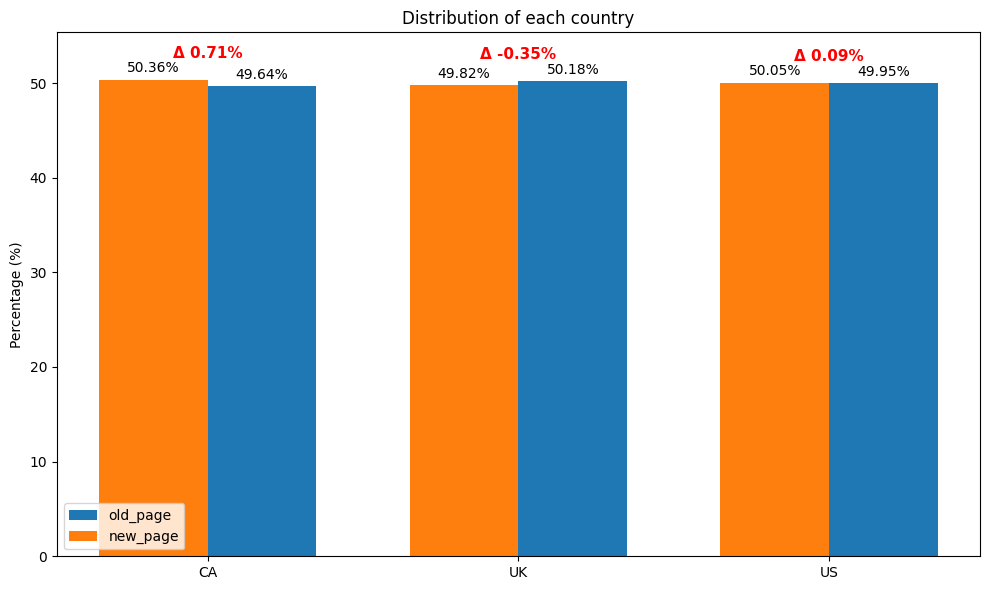

In [61]:
df_grouped = df_clean.groupby(['group','country','landing_page']).size().reset_index(name='count')

# persentase per country
df_grouped['percentage'] = df_grouped.groupby('country')['count'].transform(lambda x: (x / x.sum()) * 100)

# pivot
pivot_df = df_grouped.pivot(index='country', columns='landing_page', values='percentage')

# posisi bar
x = np.arange(len(pivot_df.index))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))  # figure lebih besar

bars1 = ax.bar(x + width/2, pivot_df['old_page'], width, label='old_page')
bars2 = ax.bar(x - width/2, pivot_df['new_page'], width, label='new_page')

# anotasi bar
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# anotasi selisih
for i, country in enumerate(pivot_df.index):
    diff = pivot_df.loc[country, 'new_page'] - pivot_df.loc[country, 'old_page']
    ax.annotate(f'Δ {diff:.2f}%',
                xy=(x[i], max(pivot_df.loc[country]) + 2),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='red')

# naikkan batas sumbu Y
ax.set_ylim(0, pivot_df.values.max() + 5)

ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of each country')
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index)
ax.legend()

plt.tight_layout()
plt.show()

# Exploratory Data Analysis

## Conversion Distribution

- independent variable = user_id, group / landing_page
- dependent variable = timestamp, converted & country

In [62]:
# count user in landing_page group
df_clean.groupby('landing_page').size()
landing_page_count_user = df_clean.groupby('landing_page').size().reset_index(name='count')
landing_page_count_user

,landing_page,count
0,new_page,145313
1,old_page,145274


### Percentage of Users in Each landing_page

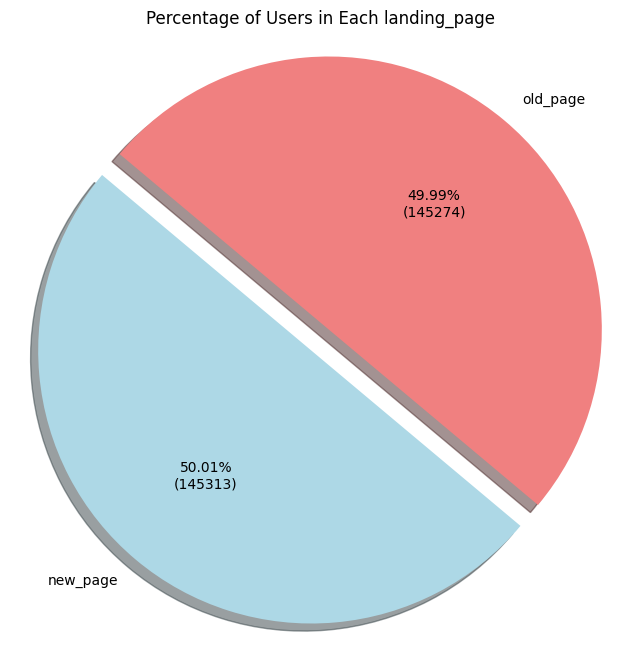

In [63]:
# visualization pie chart landing_page user

labels = landing_page_count_user['landing_page']
sizes = landing_page_count_user['count']
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)

# fungsi custom untuk menampilkan % dan jumlah
def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return "{:.2f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct=lambda pct: func(pct, sizes),
    shadow=True,
    startangle=140
)
plt.axis('equal')
plt.title('Percentage of Users in Each landing_page')
plt.show()


In [64]:
(50.01 - 49.99) * 100

1.999999999999602

### Conversion by Landing Page

In [65]:
# proportion converted each landing_page
df_clean.groupby('landing_page')['converted'].value_counts()

df_clean.groupby('landing_page')['converted'].value_counts().reset_index(name='count')

,landing_page,converted,count
0,new_page,False,128049
1,new_page,True,17264
2,old_page,False,127785
3,old_page,True,17489


In [66]:
df_plot = df_clean.groupby(['landing_page', 'converted'])['converted'].count().reset_index(name='count')

# calculate percentage each landing_page
df_plot['percentage'] = df_plot.groupby('landing_page')['count'].transform(lambda x: 100 * x / x.sum())

df_plot

,landing_page,converted,count,percentage
0,new_page,False,128049,88.119439
1,new_page,True,17264,11.880561
2,old_page,False,127785,87.961370
3,old_page,True,17489,12.038630


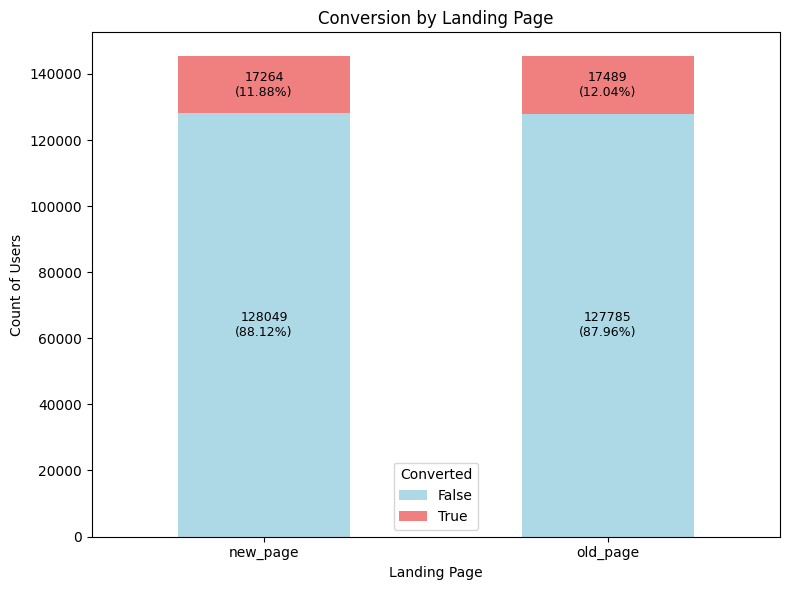

In [67]:
df_pivot = df_plot.pivot(index='landing_page', columns='converted', values='count')

# plot stacked bar
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(8,6), color=['lightblue','lightcoral'])

plt.title("Conversion by Landing Page")
plt.xlabel("Landing Page")
plt.ylabel("Count of Users")

# set label x-axis horizontal
plt.xticks(rotation=0)

# add label count + persentase on each segmen
for i, (landing_page, row) in enumerate(df_pivot.iterrows()):
    total = row.sum()
    bottom = 0
    for converted, value in row.items():
        perc = value / total * 100
        ax.text(
            i,                      # possition x
            bottom + value/2,       # possition y in the midle of bar segmen
            f"{value}\n({perc:.2f}%)",
            ha='center', va='center', fontsize=9, color="black"
        )
        bottom += value

plt.legend(title="Converted", labels=["False", "True"])
plt.tight_layout()
plt.show()


In [68]:
df_plot_country = df_clean.groupby(['country','converted']).size().reset_index(name='count')
# calculate percentage each country
df_plot_country['percentage'] = df_plot_country.groupby('country')['count'].transform(lambda x: 100 * x / x.sum())

df_plot_country

,country,converted,count,percentage
0,CA,False,12827,88.468170
1,CA,True,1672,11.531830
2,UK,False,63727,87.940551
3,UK,True,8739,12.059449
4,US,False,179280,88.045496
5,US,True,24342,11.954504


In [69]:
# make pivot
df_pivot_country = df_plot_country.pivot_table(
    index='country',
    columns='converted',
    values='count',
    aggfunc='sum'
).fillna(0)

df_pivot_country

converted,False,True
country,,
CA,12827,1672
UK,63727,8739
US,179280,24342


### User Distribution by Country

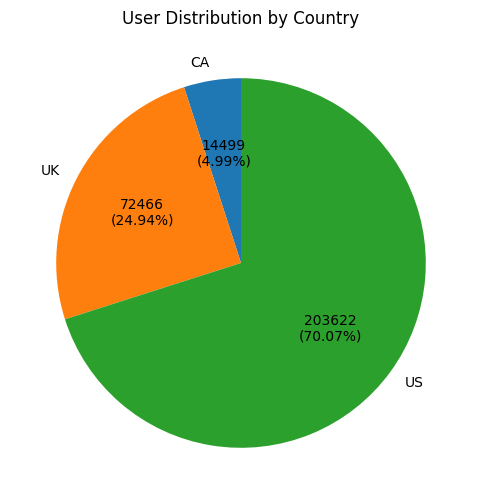

In [70]:
# total user per country
country_total = df_pivot_country.sum(axis=1)

plt.figure(figsize=(6,6))

def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{absolute}\n({pct:.2f}%)"

plt.pie(
    country_total,
    labels=country_total.index,
    autopct=lambda pct: func(pct, country_total),
    startangle=90
)
plt.title("User Distribution by Country")
plt.show()


### Conversion Distribution by Country

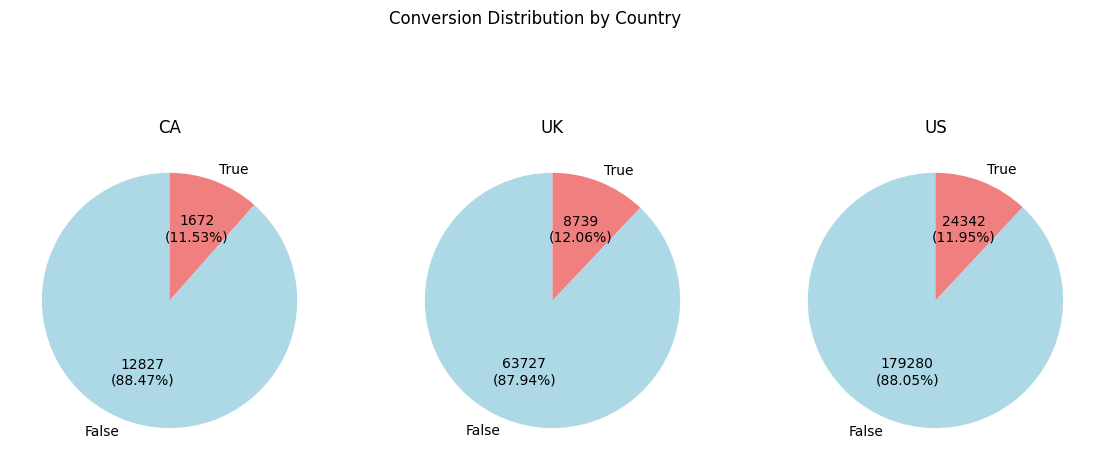

In [71]:
fig, axes = plt.subplots(1, len(df_pivot_country), figsize=(14,6))

for ax, (country, row) in zip(axes, df_pivot_country.iterrows()):
    def func(pct, allvals):
        absolute = int(round(pct/100.*sum(allvals)))
        return f"{absolute}\n({pct:.2f}%)"

    ax.pie(
        row,
        labels=row.index,
        autopct=lambda pct: func(pct, row),
        startangle=90,
        colors=['lightblue','lightcoral']
    )
    ax.set_title(f"{country}")

plt.suptitle("Conversion Distribution by Country")
plt.show()


### Conversion Distribution by Country & Landing Page

In [72]:
df_pivot_country_lp = df_clean.groupby(['country','landing_page','converted']).size().reset_index(name='count')
df_pivot_country_lp

,country,landing_page,converted,count
0,CA,new_page,False,6484
1,CA,new_page,True,817
2,CA,old_page,False,6343
3,CA,old_page,True,855
4,UK,new_page,False,31731
5,UK,new_page,True,4375
6,UK,old_page,False,31996
7,UK,old_page,True,4364
8,US,new_page,False,89834
9,US,new_page,True,12072


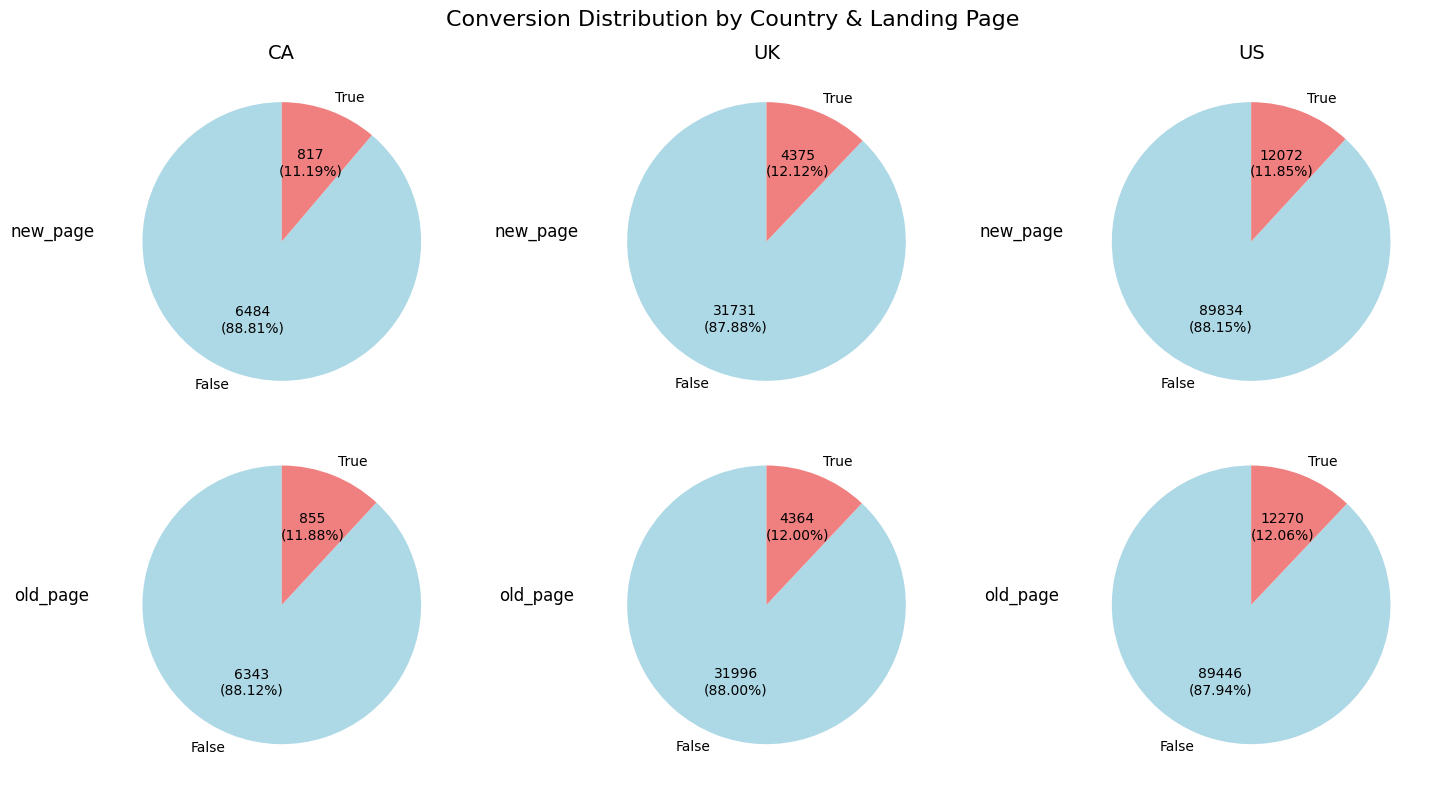

In [73]:
df_pivot_country_lp = df_pivot_country_lp.pivot_table(
    index=['country','landing_page'],
    columns='converted',
    values='count',
    aggfunc='sum'
).fillna(0)

countries = df_pivot_country_lp.index.get_level_values(0).unique()
landing_pages = ["new_page", "old_page"]

fig, axes = plt.subplots(
    nrows=len(landing_pages),
    ncols=len(countries),
    figsize=(5*len(countries), 8)
)

# loop country & landing page
for col, country in enumerate(countries):
    for row, lp in enumerate(landing_pages):
        ax = axes[row, col]
        data = df_pivot_country_lp.loc[(country, lp)]

        def func(pct, allvals):
            absolute = int(round(pct/100.*sum(allvals)))
            return f"{absolute}\n({pct:.2f}%)"

        ax.pie(
            data,
            labels=data.index,
            autopct=lambda pct: func(pct, data),
            startangle=90,
            colors=['lightblue','lightcoral']
        )
        if row == 0:
            ax.set_title(country, fontsize=14)
        ax.set_ylabel(lp, fontsize=12, rotation=0, labelpad=40)


plt.suptitle("Conversion Distribution by Country & Landing Page", fontsize=16)
plt.tight_layout()
plt.show()


In [74]:
#distribution of user converted true vs false by timestamp (visualization in power BI)
df_clean.groupby(['timestamp', 'converted']).size().reset_index(name='count')

,timestamp,converted,count
0,00:00.0,False,5
1,00:00.1,False,10
2,00:00.2,False,4
3,00:00.2,True,1
4,00:00.3,False,5
...,...,...,...
58362,59:59.7,False,9
58363,59:59.8,False,2
58364,59:59.8,True,1
58365,59:59.9,False,8


# Hypotesis Testing

## Chi-square
to answer whether the conversion rate differs significantly between landing pages or not.

### landing_page vs converted

In [75]:
from scipy.stats import chi2_contingency

# Create a contingency table landing_page vs converted
contingency_table = pd.crosstab(df_clean['landing_page'], df_clean['converted'])

print("Tabel Kontingensi:")
print(contingency_table)

#  chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)
print("\nExpected Frequencies:")
print(expected)

# Interpretation
alpha = 0.05
if p < alpha:
    print("\n There is a significant relationship between landing_page and converted (reject H0).")
else:
    print("\n There is no significant relationship between landing_page and converted (failed to reject H0).")


Tabel Kontingensi:
converted      False  True 
landing_page               
new_page      128049  17264
old_page      127785  17489

Chi-Square Statistic: 1.7089215455842974
Degrees of Freedom: 1
P-value: 0.19112535424713356

Expected Frequencies:
[[127934.16788088  17378.83211912]
 [127899.83211912  17374.16788088]]

 There is no significant relationship between landing_page and converted (failed to reject H0).


## 2 proportion z-test
compare conversion between two group of landing_page (new vs old), is there a significant difference or not

### landing_page vs converted

In [76]:
from statsmodels.stats.proportion import proportions_ztest

# ubah converted jadi integer (True=1, False=0)
df_clean['converted_int'] = df_clean['converted'].astype(int)

# hitung total success (konversi = 1) dan total user di tiap landing_page
conversion_summary = df_clean.groupby('landing_page')['converted_int'].agg(['sum', 'count'])
print(conversion_summary)

# ambil data
success = conversion_summary['sum'].values      # jumlah konversi per grup
nobs = conversion_summary['count'].values       # total sample per grup

# lakukan 2-proportion z-test (two-sided test)
stat, pval = proportions_ztest(success, nobs, alternative='two-sided')

print(f"Z-statistic = {stat:.3f}, p-value = {pval:.5f}")


                sum   count
landing_page               
new_page      17264  145313
old_page      17489  145274
Z-statistic = -1.313, p-value = 0.18919


Insight:

1. new_page 17.264 users converted, from 145.313 total users (11.88%)
2. old_page 17.489 users converted, from 145.274 (12.04%)

- Difference = -0.16% (new_page is slightly lower)
- Z-statistic -1.313 This means that the conversion difference is relatively small and insignificant.
- p-value = 0.18919 (> 0.05) , failed to reject H0.


***there is no significant evidence that new_page is better or worse than old_page. It might even be slightly worse, but the difference is very small.***




In [77]:
df_clean.head(1)

,user_id,timestamp,group,landing_page,converted,country,converted_int
0,851104,11:48.6,control,old_page,False,US,0


### landing_page vs converted by country

In [78]:
from statsmodels.stats.proportion import proportions_ztest

# Hitung jumlah sukses (converted_int=1) dan total per country + landing_page
summary = df_clean.groupby(['country','landing_page']).agg(
    success=('converted_int','sum'),
    total=('converted_int','count')
).reset_index()

# Loop per country untuk uji z-test (new vs old)
for c in summary['country'].unique():
    sub = summary[summary['country']==c].sort_values('landing_page')
    success = sub['success'].values
    total = sub['total'].values

    stat, pval = proportions_ztest(success, total)
    conv_rates = success / total

    print(f"\nCountry: {c}")
    print(f"Conversion rates: new={conv_rates[sub['landing_page'].values.tolist().index('new_page')]:.4%}, "
          f"old={conv_rates[sub['landing_page'].values.tolist().index('old_page')]:.4%}")
    print(f"Z-stat={stat:.3f}, p-value={pval:.4f}")
    if pval < 0.05:
        print("➡️ Significant: there is a difference in new vs old conversions")
    else:
        print("➡️ Not significant: no evidence of conversion difference")



Country: CA
Conversion rates: new=11.1902%, old=11.8783%
Z-stat=-1.297, p-value=0.1947
➡️ Not significant: no evidence of conversion difference

Country: UK
Conversion rates: new=12.1171%, old=12.0022%
Z-stat=0.475, p-value=0.6349
➡️ Not significant: no evidence of conversion difference

Country: US
Conversion rates: new=11.8462%, old=12.0630%
Z-stat=-1.508, p-value=0.1316
➡️ Not significant: no evidence of conversion difference


insight:

- All p-values ​​> 0.05 → no significant evidence that new_page is better in any country.

***there is no significant evidence that new_page is better or worse than old_page. It might even be slightly worse, but the difference is very small.***

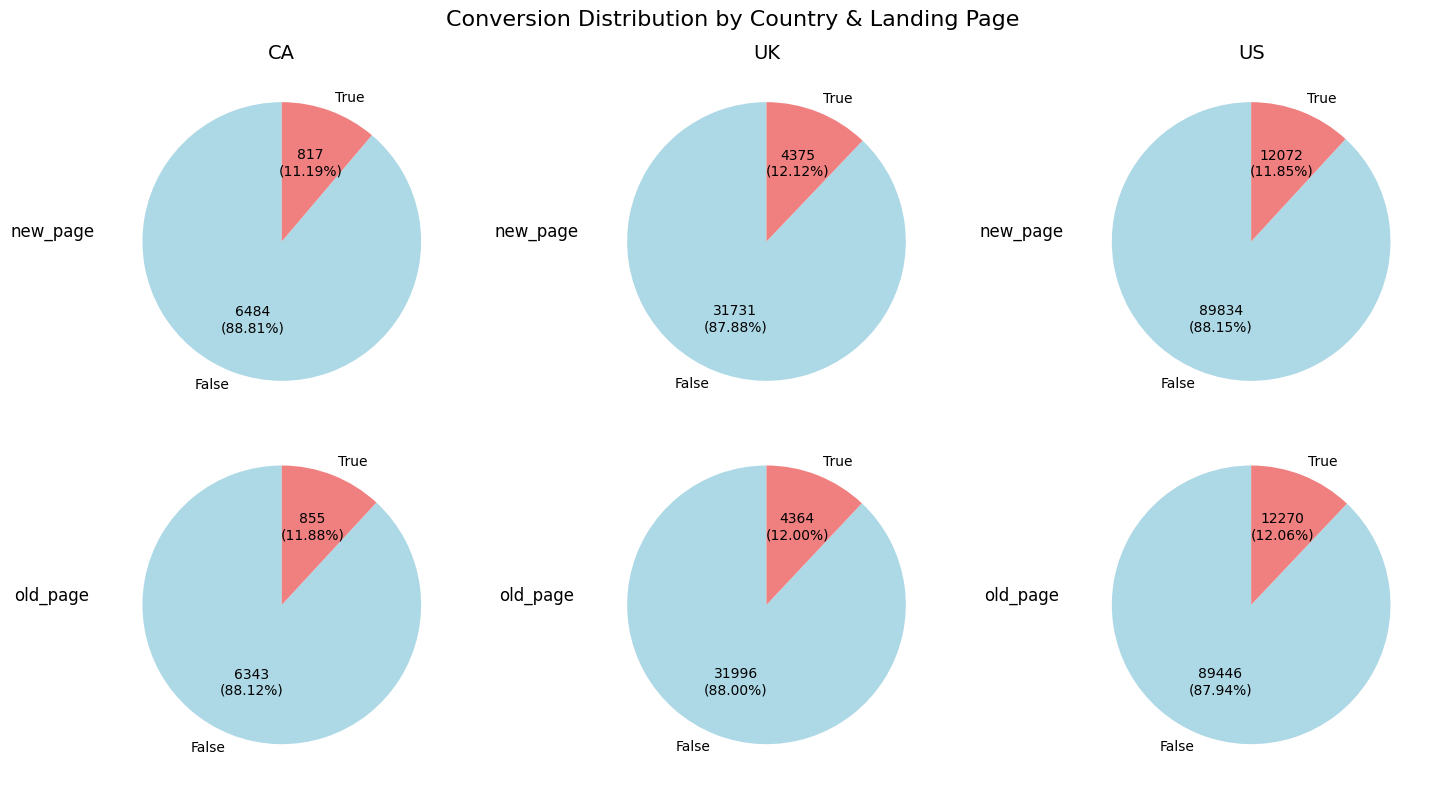

## Validation test

### confidence interval (CI) landing_page vs converted
This CI gives an idea of ​​the true range of effects, not just the p-value.

In [79]:
import statsmodels.api as sm

# data summary
success = conversion_summary['sum'].values      # jumlah konversi per grup
nobs = conversion_summary['count'].values   # total sample per grup

# proporsi konversi
p_new, p_old = success / nobs # konversion rate new & old
diff = p_new - p_old           # selisih konversion nya

# standard error
se = np.sqrt(p_new*(1-p_new)/nobs[0] + p_old*(1-p_old)/nobs[1])

# Z untuk CI 95% = 1.96
z = 1.96
ci_low, ci_high = diff - z*se, diff + z*se

print(f"Conversion rate new_page = {p_new:.4%}")
print(f"Conversion rate old_page = {p_old:.4%}")
print(f"Difference = {diff:.4%}")
print(f"95% CI for difference = ({ci_low:.4%}, {ci_high:.4%})")


Conversion rate new_page = 11.8806%
Conversion rate old_page = 12.0386%
Difference = -0.1581%
95% CI for difference = (-0.3940%, 0.0779%)


Insight:

Conversion rate new_page = 11.8806%
Conversion rate old_page = 12.0386%
Difference = -0.1581%
95% CI for difference = (-0.3940%, 0.0779%)


- Since the CI includes 0, there is no significant evidence that new_page is better/worse.

- The effect is very small, almost neutral.

***the possible impact of the new page will only range from slightly worse to slightly better, but there will be no major effect.***

### Power test



In [80]:
import statsmodels.api as sm

# parameter
alpha = 0.05
power = 0.8

# baseline conversion rate
p_old = 0.1204
# minimal detectable effect (misal 0.01 = 1% absolut)
mde = 0.01
p_new = p_old + mde

effect_size = sm.stats.proportion_effectsize(p_old, p_new)

analysis = sm.stats.NormalIndPower()
sample_size = analysis.solve_power(effect_size=effect_size,
                                   power=power,
                                   alpha=alpha,
                                   ratio=1)
print(f"Sample size per group needed: {sample_size:.0f}")


Sample size per group needed: 17210


- Minimum sample size required per group = 17,210
- Actual data > 17,210 = 145,000+ each group
- the data is well-powered to detect small differences.

***Since the results remain neutral, it is highly likely that there is no significant effect on conversion rates.***

In [81]:
df_clean['landing_page'].value_counts()

,count
landing_page,
new_page,145313
old_page,145274


***sample per group > 17.210, The experiment is very strong enough to state the Minimum Detectable Effect (MDE), the results of the statistical test can be said to be valid***

# interpretation & insight



1. There is no significant evidence that new_page increases conversions over old_page.
2. The conversion difference is very small (around -0.16%), and the CI indicates that the maximum effect is only ±0.3–0.4%.
→ From a business perspective, a difference this small is usually not worth making a major change.
3. The experiment was well-powered (large sample size, 145,000 vs. 145,000, well above the minimum requirement).
→ So, this neutral result is not due to a lack of data, but rather due to the absence of a significant effect.


- ***The new page didn't provide a significant increase in conversions. With such a large sample size, we can be fairly certain the difference is very small. If the primary goal is to increase conversion rates, the new page doesn't provide any benefit.***

- ***It is not recommended to roll out new pages based solely on conversion metrics → as there is no significant evidence of improvement. If implementation costs are high, it's better to stick with old_page.***



In [82]:
# save to file excel
df_clean.to_excel('ecommerce_ab_testing_clean.xlsx', index=False)

# Referensi

- Dataset
https://www.kaggle.com/datasets/putdejudomthai/ecommerce-ab-testing-2022-dataset1
- Sample Ratio Mismatch (SRM) https://www.convert.com/blog/a-b-testing/sample-ratio-mismatch-srm-guide
